Technical Analysis libraries:   
* pip install TA-Lib         ---- 150 + indicators, supports work with pandasd. TA-Lib is the golden standard, but it is not the easiest one to understand and dive deep into.
* pip install --upgrade ta   ---- 42 indicators, supports work with pandas. ( Can run all 42 indicators in one line of code).  
* pip install pandas_ta      ---- 130+ indicators, supports work with pandas.   

*** Read more here : https://medium.com/geekculture/top-4-python-libraries-for-technical-analysis-db4f1ea87e09

Portfolio Assessment libraries:
* pip install pyfolio -- Portfolio analysis (seems like it is not supported anymore)
   


In [7]:
import requests as r
import pandas as pd 
import numpy as np
import json as j
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplfinance as mpf

KEY = '4239092CFMPXI6YI' # alphavantage.co API key
STOCK_LIST = ['MSFT','TSLA','BABA','VZ','AAPL', 'NEM'] # 

### Getting data from aplha vantage API and storing it in csv files

Daily data:

In [3]:
def get_daily_adjusted_data(ticker,key):
    url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey={key}&outputsize=full'
    response = r.get(url_json)
    j_response = response.json()
    formated_response = j.dumps(j_response, indent=4)
    return formated_response

In [4]:
# for ticker in STOCK_LIST:
#     data = get_daily_adjusted_data(ticker,KEY)
#     data = j.loads(data)
#     data = data['Time Series (60min)']
#     df = pd.DataFrame(data)
#     df = df.transpose()
#     df.to_csv(f'..\P1-Indicators-Chart-Analysis\Data\Daily\{ticker}-hourly.csv')

Hourly data: (for the last 2 years)

In [138]:
def get_intraday_extended_data(ticker,key,interval='60min',slice='year1month1'):
    if slice == '2yearData':
        months = ['1','2','3','4','5','6','7','8','9','10','11','12']
        years = ['1','2']
        with open(f'..\P1-Indicators-Chart-Analysis\Data\Hourly\{ticker}-2years-hourly.csv', 'w') as f:
            for year in years:
                for month in months:
                    slice = f'year{year}month{month}'
                    url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={ticker}&interval={interval}&slice={slice}&apikey={key}'
                    response = r.get(url_json)
                    f.write(response.text)
                    time.sleep(13) # API limit is 5 calls per minute
    else:
        url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={ticker}&interval={interval}&slice={slice}&apikey={key}'
        response = r.get(url_json)
        with open(f'..\P1-Indicators-Chart-Analysis\Data\Hourly\{ticker}-30days-hourly.csv', 'w') as f:
            f.write(response.text)

In [139]:
# for ticker in STOCK_LIST:
#     get_intraday_extended_data(ticker,KEY,slice='2yearData')

### Data Visualization and Chart Analysis

In [140]:
# load data from csvs
aapl_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\AAPL-daily.csv', index_col=0,parse_dates=True)
baba_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\BABA-daily.csv', index_col=0,parse_dates=True)
msft_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\MSFT-daily.csv', index_col=0,parse_dates=True)
nem_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\NEM-daily.csv', index_col=0,parse_dates=True)
tsla_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\TSLA-daily.csv', index_col=0,parse_dates=True)
vz_d_source= pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\VZ-daily.csv', index_col=0,parse_dates=True)

aapl_d_source.index.rename('Date', inplace=True)
baba_d_source.index.rename('Date', inplace=True)
msft_d_source.index.rename('Date', inplace=True)
nem_d_source.index.rename('Date', inplace=True)
tsla_d_source.index.rename('Date', inplace=True)
vz_d_source.index.rename('Date', inplace=True)

In [141]:
aapl_d_source.head(2)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2023-03-10,150.210,150.940,147.6096,148.50,148.50,68572400,0.0,1.0
2023-03-09,153.559,154.535,150.2250,150.59,150.59,53833582,0.0,1.0


Check if data is actually adjusted for splits and dividends as it should be per the API documentation:

In [30]:
aapl_d_source['8. split coefficient'].value_counts()

1.000000    5873
2.000000       2
4.000000       1
7.000007       1
Name: 8. split coefficient, dtype: int64

In [5]:
splits = aapl_d_source[~aapl_d_source['8. split coefficient'].isin([1])].copy(deep=True)
splits['8. split coefficient'] = splits['8. split coefficient'].astype('int')
splits

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2020-08-31,127.58,131.00,126.00,129.04,126.935683,223505733,0.0,4
2014-06-09,92.70,93.88,91.75,93.70,20.831391,75414997,0.0,7
2005-02-28,44.68,45.14,43.96,44.86,1.361730,11635900,0.0,2
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2


Quick check online confirms that these are the dates of the splits for AAPL stock.  
Let's see if the next day's open price is adjusted for the split.

In [6]:
aapl_d_source.loc['2000-06-19':'2000-06-26':-1]
# aapl_d_source.loc['2005-02-24':'2005-03-01':-1]
# aapl_d_source.loc['2014-06-06':'2014-06-11':-1]
# aapl_d_source.loc['2020-08-27':'2020-09-02':-1]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2000-06-19,90.56,97.87,89.81,96.62,0.733228,3517900,0.0,1.0
2000-06-20,98.50,103.94,98.37,101.25,0.768364,4476700,0.0,1.0
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2.0
2000-06-22,55.75,57.63,53.56,53.75,0.815794,8352000,0.0,1.0
2000-06-23,53.78,54.63,50.81,51.69,0.784528,3660100,0.0,1.0
2000-06-26,52.50,54.75,52.13,54.13,0.821561,3309900,0.0,1.0


As we can see the column "5. adjusted close" indicates the adjusted close price for the split. Great.   
However to use some of the indicators we need to use the high, low, open and close prices.

In [8]:
for split in splits.index:
    aapl_d_source.loc[split-timedelta(days=1):,'1. open'] = aapl_d_source.loc[split:,'1. open'] / splits.loc[split,'8. split coefficient']
    aapl_d_source.loc[split-timedelta(days=1):,'2. high'] = aapl_d_source.loc[split:,'2. high'] / splits.loc[split,'8. split coefficient']
    aapl_d_source.loc[split-timedelta(days=1):,'3. low'] = aapl_d_source.loc[split:,'3. low'] / splits.loc[split,'8. split coefficient']
    aapl_d_source.loc[split-timedelta(days=1):,'4. close'] = aapl_d_source.loc[split:,'4. close'] / splits.loc[split,'8. split coefficient']    

Adjusting for the splits:

In [9]:
aapl_d_source.loc['2000-06-19':'2000-06-26':-1]
# aapl_d_source.loc['2005-02-24':'2005-03-01':-1]
# aapl_d_source.loc['2014-06-06':'2014-06-11':-1]
# aapl_d_source.loc['2020-08-27':'2020-09-02':-1]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2000-06-19,0.808571,0.873839,0.801875,0.862679,0.733228,3517900,0.0,1.0
2000-06-20,0.879464,0.928036,0.878304,0.904018,0.768364,4476700,0.0,1.0
2000-06-21,0.901786,1.016786,0.898393,0.993393,0.844327,4375000,0.0,2.0
2000-06-22,0.995536,1.029107,0.956429,0.959821,0.815794,8352000,0.0,1.0
2000-06-23,0.960357,0.975536,0.907321,0.923036,0.784528,3660100,0.0,1.0
2000-06-26,0.937500,0.977679,0.930893,0.966607,0.821561,3309900,0.0,1.0


* Saving function to reuse later. Adding some column elimination as well.   
Since we adjusting data only for splits, we can eliminate the columns which account for dividends for now.

In [128]:
def adjust_price_for_splits(df):
    splits = df[~df['8. split coefficient'].isin([1])].copy(deep=True)
    splits['8. split coefficient'] = splits['8. split coefficient'].astype('int')
    for split in splits.index:
        df.loc[split-timedelta(days=1):,'1. open'] = df.loc[split:,'1. open'] / splits.loc[split,'8. split coefficient']
        df.loc[split-timedelta(days=1):,'2. high'] = df.loc[split:,'2. high'] / splits.loc[split,'8. split coefficient']
        df.loc[split-timedelta(days=1):,'3. low'] = df.loc[split:,'3. low'] / splits.loc[split,'8. split coefficient']
        df.loc[split-timedelta(days=1):,'4. close'] = df.loc[split:,'4. close'] / splits.loc[split,'8. split coefficient']  
    df = df.rename(columns={'1. open':'Open', '2. high':'High', '3. low':'Low', '4. close':'Close', '6. volume':'Volume'})
    df = df[::-1]
    return df, splits

In [142]:
aapl_d, aapl_splits = adjust_price_for_splits(aapl_d_source)
baba_d, baba_splits = adjust_price_for_splits(baba_d_source)
msft_d, msft_splits = adjust_price_for_splits(msft_d_source)
nem_d, nem_splits = adjust_price_for_splits(nem_d_source)
tsla_d, tsla_splits = adjust_price_for_splits(tsla_d_source)
vz_d, vz_splits = adjust_price_for_splits(vz_d_source)

# For Easy access to the data and manipulation
growth = [aapl_d, baba_d, msft_d, tsla_d]
value = [nem_d, vz_d]
all_stocks = [aapl_d, baba_d, msft_d, nem_d, tsla_d, vz_d]

#### Plotting stock price and volume for the last 2 years

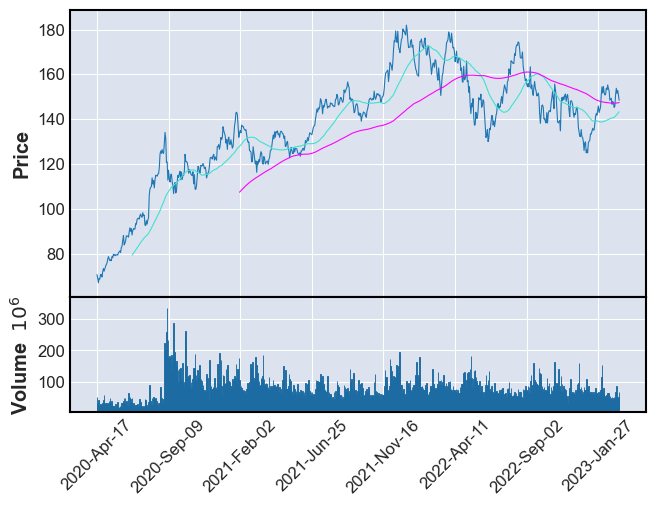

In [124]:
mpf.plot(aapl_d[-730::], type='line',  volume=True,  mav=(50, 200)) # quick plot

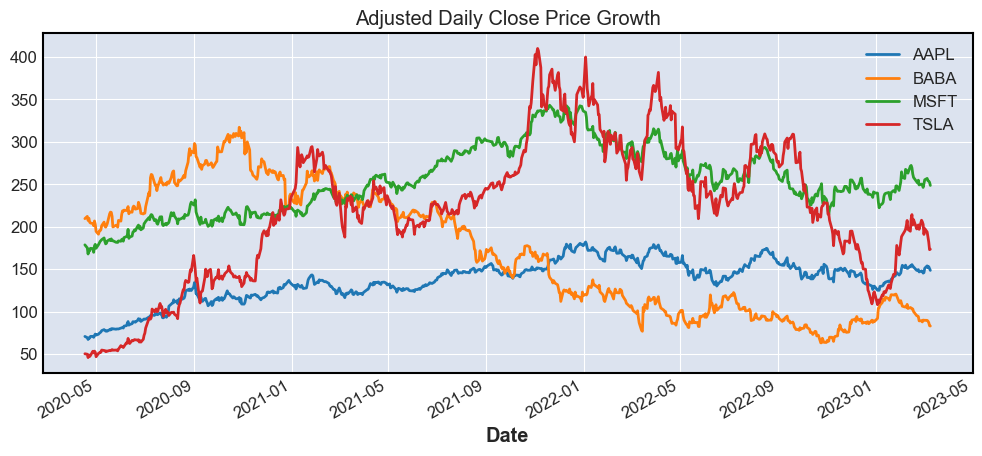

In [127]:
aapl_d['Close'][-730::].plot(figsize=(12,5),label='AAPL', title='Adjusted Daily Close Price Growth')
baba_d['Close'][-730::].plot(label='BABA')
msft_d['Close'][-730::].plot(label='MSFT')
tsla_d['Close'][-730::].plot(label='TSLA')
plt.legend()

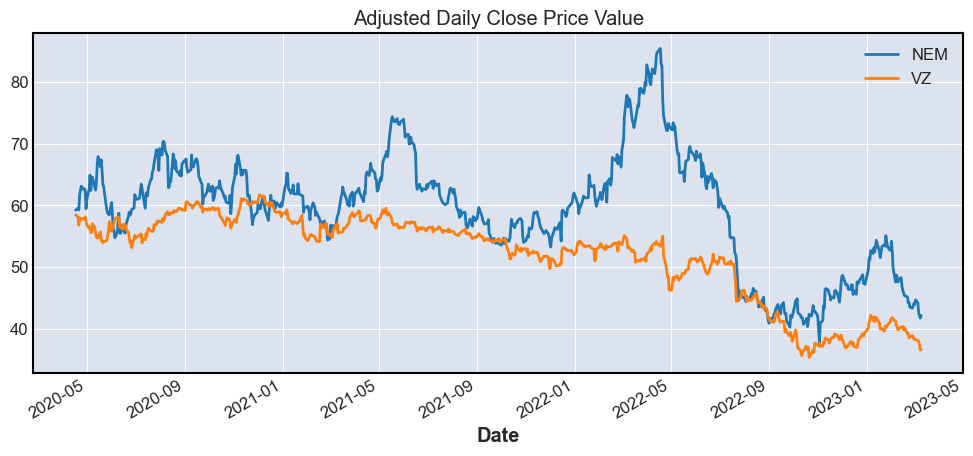

In [130]:
nem_d['Close'][-730::1].plot(label='NEM',figsize=(12,5), title='Adjusted Daily Close Price Value')
vz_d['Close'][-730::1].plot(label='VZ')
plt.legend()

In [145]:
for stock in all_stocks:
    stock['MA30'] = stock['Close'].rolling(30).mean()
    stock['MA120'] = stock['Close'].rolling(120).mean()

<Axes: title={'center': 'APPL MA30 and MA150'}, xlabel='Date'>

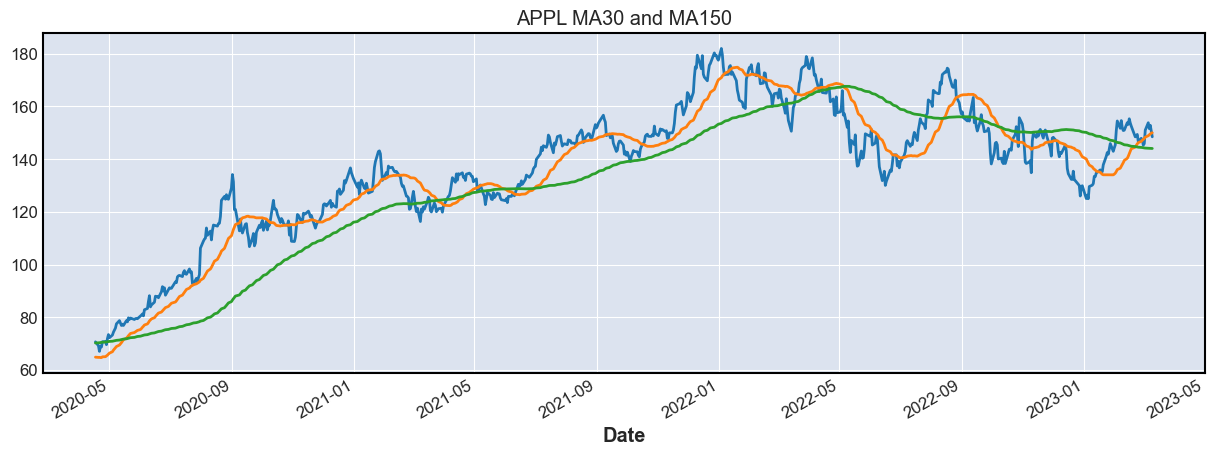

In [147]:
aapl_d['Close'][-730::].plot(figsize=(15,5),label='AAPL', title='APPL MA30 and MA150')
aapl_d['MA30'][-730::].plot(label='MA30')
aapl_d['MA120'][-730::].plot(label='MA120')

In [148]:
aapl_d.head()

,Open,High,Low,Close,5. adjusted close,Volume,7. dividend amount,8. split coefficient,MA30,MA120
Date,,,,,,,,,,
1999-11-01,0.714286,0.720446,0.690804,0.693036,0.589041,2487300,0.0,1.0,NaN,NaN
1999-11-02,0.696429,0.729375,0.690268,0.716518,0.608999,3564600,0.0,1.0,NaN,NaN
1999-11-03,0.728750,0.743304,0.723214,0.727679,0.618485,2932700,0.0,1.0,NaN,NaN
1999-11-04,0.732679,0.762232,0.719821,0.746607,0.634574,3384700,0.0,1.0,NaN,NaN
1999-11-05,0.755536,0.789018,0.750000,0.788482,0.670165,3721500,0.0,1.0,NaN,NaN
